# JupyerLab notebook reproducing R. Labarbe results

/!\ /!\ /!\  
Oxygen diffusion from cell environment not (yet) included in the model.  
Therefore, the oxygen level is reinitialized before each new pulse.  

## Module imports

In [1]:
# External modules (to "pip install")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson, cumulative_trapezoid

# Modules from Standard lib
from pathlib import Path

# RadioBio module
import radiopyo as rp
from radiopyo.physics.beam import PulsedBeam, ConstantBeam

In [2]:
from Plot_template import RPlot, FigManager
RPlot.init_rcparams()
fig_man = FigManager()

ModuleNotFoundError: No module named 'Plot_template'

## Simulation Run

In [3]:
uc = rp.UnitCell.from_toml("config_SiongTan.toml")

2023-11-19 20:48:24,383::radiopyo::INFO::Loading config from file: config_SiongTan.toml
2023-11-19 20:48:24,390::radiopyo::INFO::Resolving include: C:\Users\daraa\Dev\radiopyo\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-11-19 20:48:24,630::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-11-19 20:48:24,632::radiopyo::INFO::Resolving include: C:\Users\daraa\Dev\radiopyo\radiopyo\radiopyo\data\reactions_biology.toml
2023-11-19 20:48:24,704::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-11-19 20:48:25,049::radiopyo::WARNING::Unable to compute mass of GSH. Setting it to default mass, i.e. 0
2023-11-19 20:48:25,075::radiopyo::INFO::File is loaded
2023-11-19 20:48:25,076::radiopyo::INFO::Beam configuration detected in config file
2023-11-19 20:48:25,076::radiopyo::INFO::BEAM:: Assigning 'default' name to beam definition constant -> {'dose_rate': 10000000.0, 'max_dose': 10, 'start_time': 0.0, 'LET

In [6]:
uc.beam_list.current

ConstantBeam(dose_rate=1, timer=Timer(period=inf, on_time=inf, start_time=0.0), max_dose=10, label='default', time_at_max_dose=10.0, dose_per_pulse=inf, peak_dose_rate=1.0)

In [5]:
dose_rate = [1, 10, 1e3, 1e5, 1e7]
sims = dict()

for idx, value in enumerate(dose_rate):
    print(f"Simulating conv: {value} Gy")
    uc.beam_list.current.update_beam_param(dose_rate=value)
    sim = uc.prepare_chunked_run([1e-9, 600], atol=1e-8, rtol=1e-4, use_jac=False)
    res = sim.run()
    sims[value] = res.to_pandas()





Simulating conv: 1 Gy
2023-07-28 13:07:51,112::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-28 13:07:51,115::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-28 13:07:51,685::radiopyo::INFO::Simulation done!
Simulating conv: 10 Gy
2023-07-28 13:07:51,689::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-28 13:07:51,692::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-28 13:07:52,003::radiopyo::INFO::Simulation done!
Simulating conv: 1000.0 Gy
2023-07-28 13:07:52,007::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-28 13:07:52,009::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-28 13:07:52,435::radiopyo::INFO::Simulation done!
Simulating conv: 100000.0 Gy
2023-07-28 13:07:52,438::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-28 13:07:52,441::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-28 13:07:52,914::radiopyo::INFO::Simulation done!
Simulating conv: 10000000.0 Gy
2023-07-28 13:07:52,917::radiopyo::INFO::Simulation divided in 2 chunks
2023-07-28 13:07:52,920::radiopyo::INFO::Running all simulation chunks


  0%|          | 0/2 [00:00<?, ?it/s]

2023-07-28 13:07:53,306::radiopyo::INFO::Simulation done!


## Results usage

**Integrate values per pulse**

In [12]:
by_pulse = pd.DataFrame(columns=df.columns)
for pulse in range(int(PULSES_NUMBER)):
    by_pulse.loc[pulse, :] = res.integrate_species(start=pulse*uc.beam.timer.period, stop=(pulse+1)*uc.beam.timer.period)

### Plot

In [8]:
# Some common plot options for uniformity
RIGHT_LIMIT = 1e3
save_to = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\STUDIES\PULSE_STRUCTURE\bordet")

def save_fig(fig, title):
    if not save_to.exists():
        raise FileNotFoundError(f"Folder: {save_to} does not exists")
        return
    fig.savefig(save_to/f"{title}.png", transparent=True)
    
from operator import attrgetter

def adapt_xticks(ref, ax, around=None):
        """
        Adapt tick location of ax to fit with ref.
        """
        loc = np.around(RPlot.get_ticks_loc(ref, "x"), 3)
        loc = loc[np.where(np.logical_and(loc[:, 0] >= 0, loc[:, 0] <= 1.001))]
        out = RPlot.axis_to_data(ax, loc)
        if around is not None:
            out = np.around(out, int(around))
        ax.xaxis.set_ticks(out[:, 0])
        return out

def make_label(value) -> str:
    return f"{value[0]} - {value[1]} Gy"

#### Biology related species

In [12]:
sims.keys()

dict_keys([0, 1, 2, 3, 4])

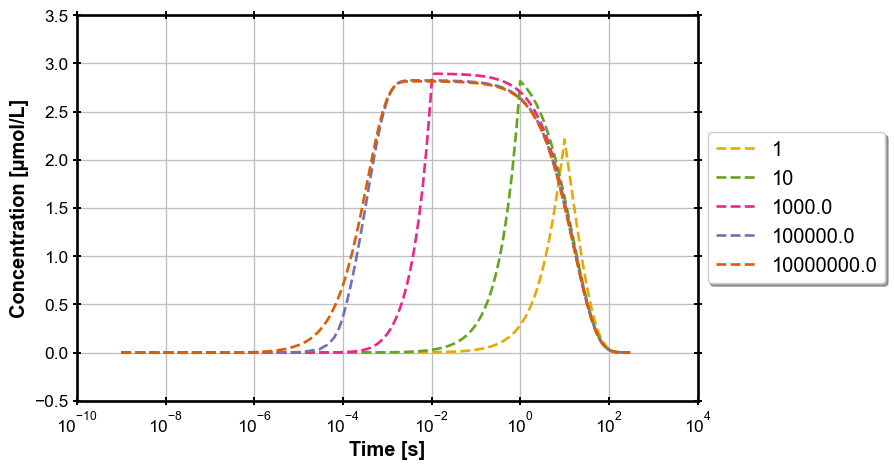

In [10]:
species = "ROO_r"
fig_man.set_brewer_map("Dark2", "qualitative", 6, reverse=True)
with fig_man.open(f"CONV Comparison of {species}") as (fig, ax):
    for value, df in sims.items():
        ax.plot(df.index, df[species], label=value, marker="")

    #ax.set_ylim(bottom=1e-6, top=2)
    #ax.set_xlim([1e-6, RIGHT_LIMIT])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    #ax.set_title("Biology related species")


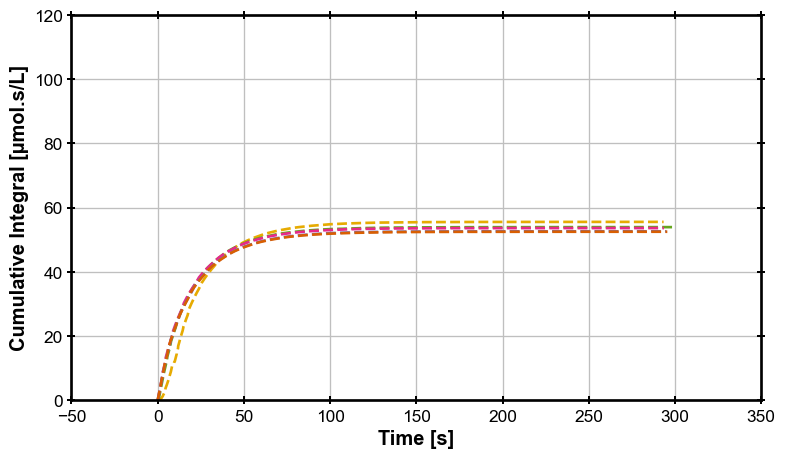

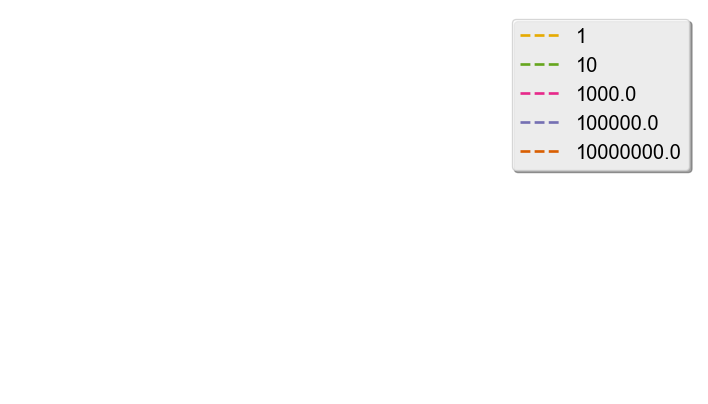

In [11]:
species = "ROO_r"
with fig_man.open(f"Conv - Cum Trapz{species}") as (fig, ax):
    for value, df in sims.items():
        l, = ax.plot(df.index[:-1],
                     cumulative_trapezoid(x=df.index.values,y=df["ROO_r"]),
                     label=value,
                     marker="")
    ax.set_ylim([0,120])
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #RPlot.set_legend_right(ax)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Cumulative Integral [µmol.s/L]")
    
fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
#fig_l.set_size_inches(bbox.width, bbox.height)
#fig_l.tight_layout()
#fig.savefig(root/"Reactions_e_aq_10ppm_2000kGy.png")
#fig_l.savefig(root/"Reactions_e_aq_10ppm_legend_2000kGy.png", bbox_inches=bbox.expanded(1.02,1.04), transparent=True)

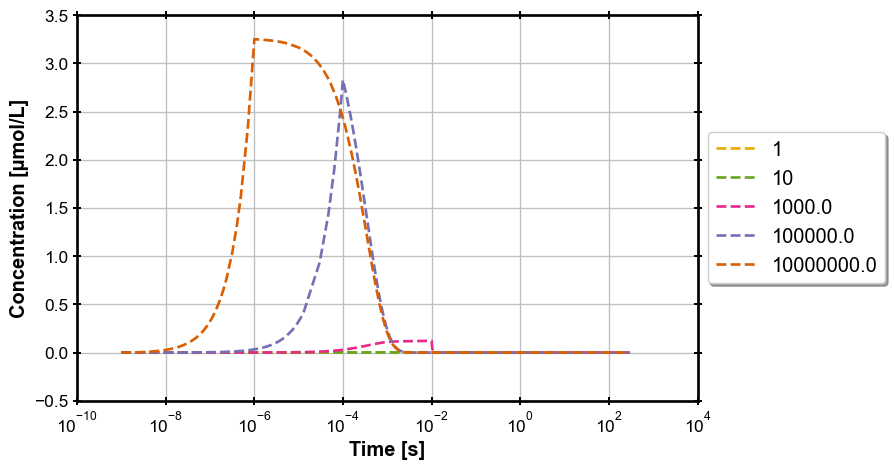

In [12]:
species = "R_r"
fig_man.set_brewer_map("Dark2", "qualitative", 6, reverse=True)
with fig_man.open(f"CONV Comparison of {species}") as (fig, ax):
    for value, df in sims.items():
        ax.plot(df.index, df[species], label=value, marker="")

    #ax.set_ylim(bottom=1e-6, top=2)
    #ax.set_xlim([1e-6, RIGHT_LIMIT])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    #ax.set_title("Biology related species")


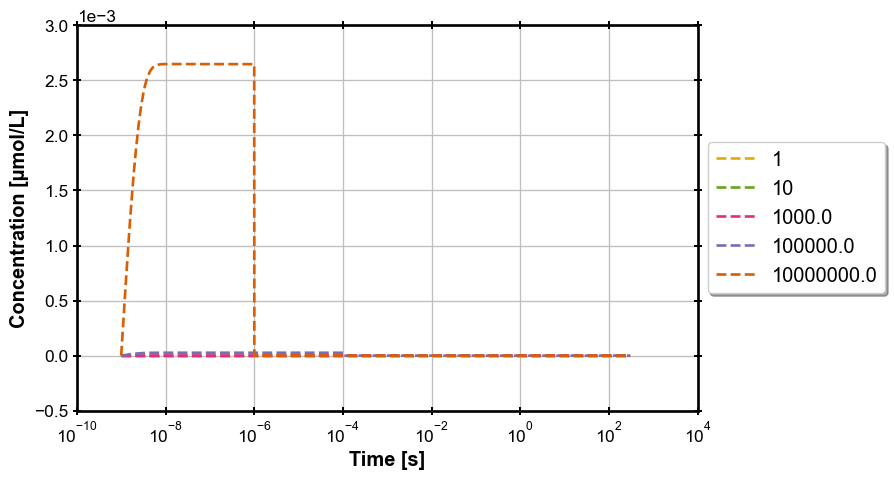

In [13]:
species = "OH_r"
fig_man.set_brewer_map("Dark2", "qualitative", 6, reverse=True)
with fig_man.open(f"CONV Comparison of {species}") as (fig, ax):
    for value, df in sims.items():
        ax.plot(df.index, df[species], label=value, marker="")

    #ax.set_ylim(bottom=1e-6, top=2)
    #ax.set_xlim([1e-6, RIGHT_LIMIT])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    #ax.set_title("Biology related species")


#### O2

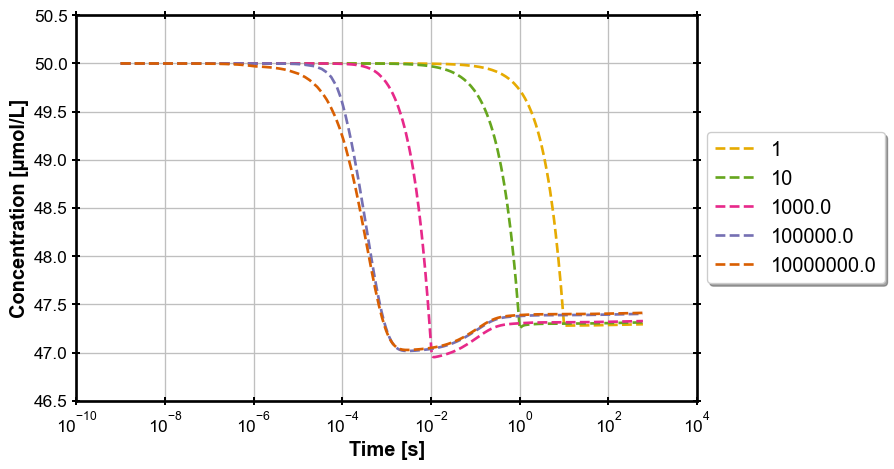

In [6]:
species = "O2"
fig_man.set_brewer_map("Dark2", "qualitative", 6, reverse=True)
with fig_man.open(f"CONV Comparison of {species}") as (fig, ax):
    for value, df in sims.items():
        ax.plot(df.index, df[species], label=value, marker="")

    #ax.set_ylim(bottom=1e-6, top=2)
    #ax.set_xlim([1e-6, RIGHT_LIMIT])
    #ax.set_xlim([0, 100])
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    RPlot.set_legend_right(ax)
    #ax.legend(fancybox=True, framealpha=1)
    #ax.set_title("Biology related species")


## Compare Chemical reaction rates

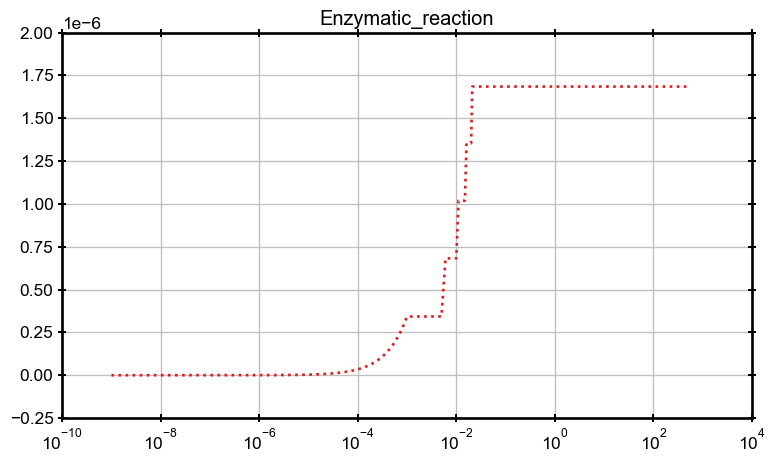

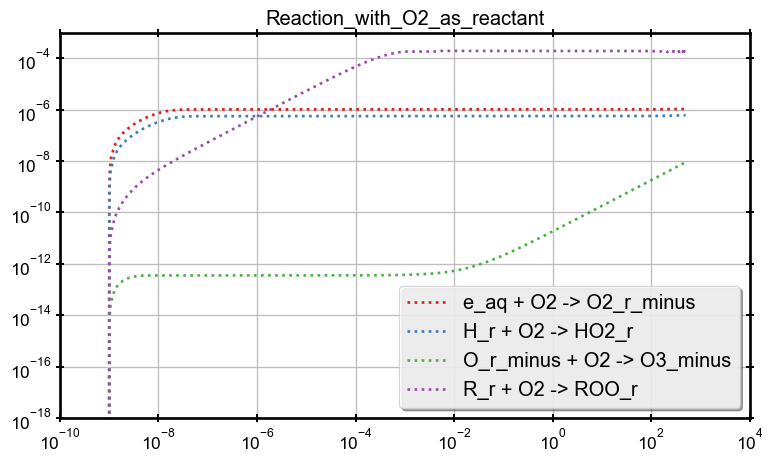

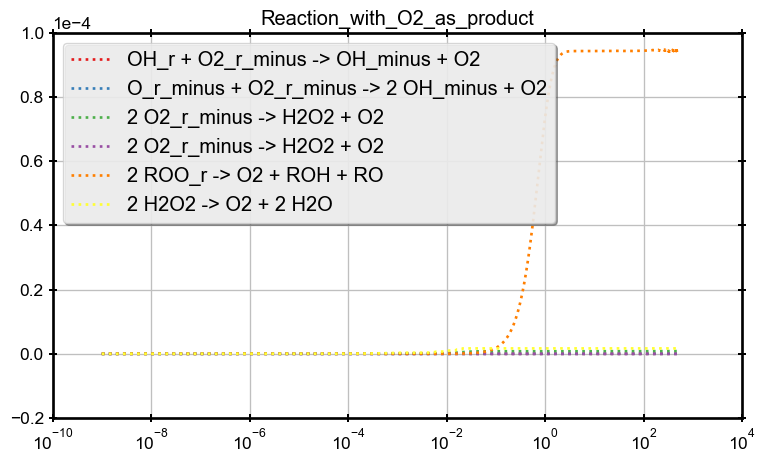

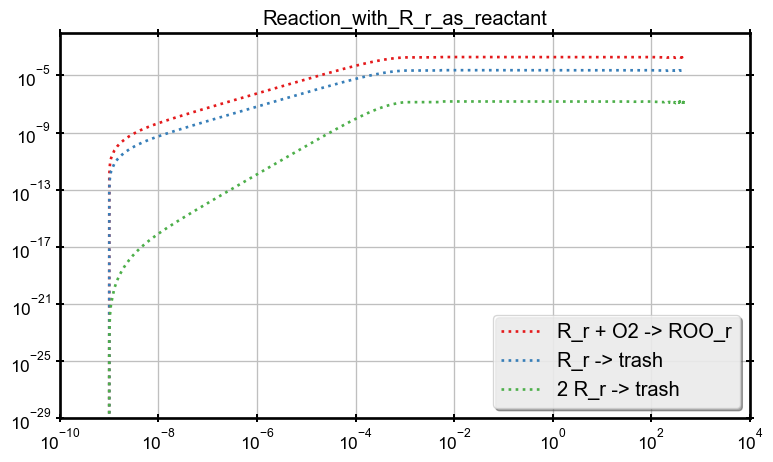

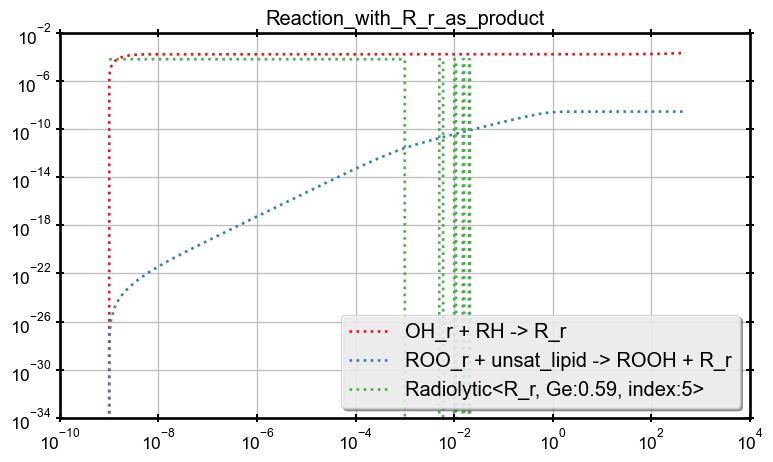

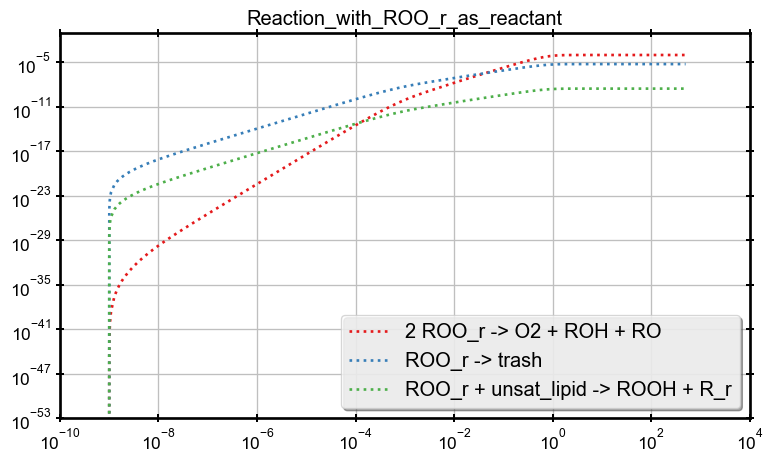

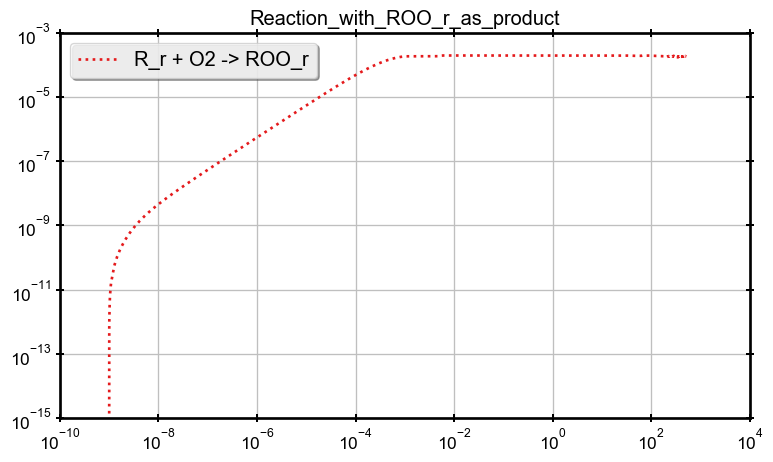

C:\Users\rtonneau\AppData\Local\Temp\ipykernel_18404\1964718746.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


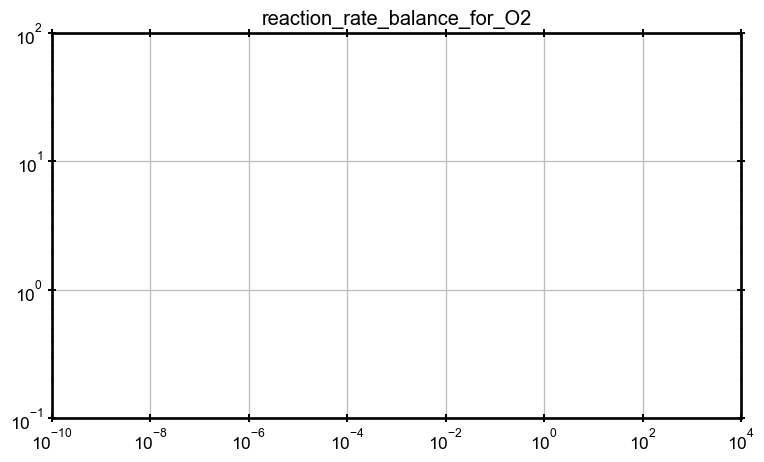

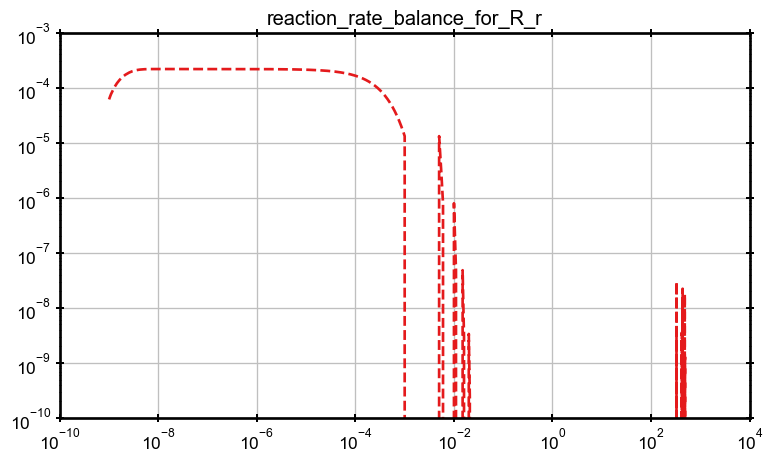

In [15]:
res = all_res[5e-3]
df_r = res.reconstruct_reactions()
df_b = res.species_balance_evolution()

fig_man.set_brewer_map("Set1", "qualitative", 6, reverse=False)

with fig_man.open(f"Enzymatic reaction") as (fig, ax):
    ax.semilogx(df_r.index, df_r["EZ_0"], label="fEZ_0", marker="", linestyle=":")
    ax.set_title(fig_man.last)

        
with fig_man.open(f"Reaction with O2 as reactant") as (fig, ax):
    for reaction in res.env.reactions_involving_reactant("O2"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")
        ax.legend()
        ax.set_title(fig_man.last)
        ax.set_yscale("log")

with fig_man.open(f"Reaction with O2 as product") as (fig, ax):
    for reaction in res.env.reactions_involving_product("O2"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")
        ax.legend()
        ax.set_title(fig_man.last)


with fig_man.open(f"Reaction with R_r as reactant") as (fig, ax):
    for reaction in res.env.reactions_involving_reactant("R_r"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")
    ax.legend()
    ax.set_title(fig_man.last)
    ax.set_yscale("log")
    

with fig_man.open(f"Reaction with R_r as product") as (fig, ax):
    for reaction in res.env.reactions_involving_product("R_r"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")
    ax.legend()
    ax.set_title(fig_man.last)
    ax.set_yscale("log")

with fig_man.open(f"Reaction with ROO_r as reactant") as (fig, ax):
    for reaction in res.env.reactions_involving_reactant("ROO_r"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")
    ax.legend()
    ax.set_title(fig_man.last)
    ax.set_yscale("log")
    

with fig_man.open(f"Reaction with ROO_r as product") as (fig, ax):
    for reaction in res.env.reactions_involving_product("ROO_r"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")
    ax.legend()
    ax.set_title(fig_man.last)
    ax.set_yscale("log")

    
with fig_man.open(f"reaction rate balance for O2") as (fig, ax):
    ax.semilogx(df_b.index, df_b["O2"], marker="")
    ax.set_title(fig_man.last)
    ax.set_yscale("log")

with fig_man.open(f"reaction rate balance for R_r") as (fig, ax):
    ax.semilogx(df_b.index, df_b["R_r"], marker="")
    ax.set_title(fig_man.last)
    ax.set_yscale("log")

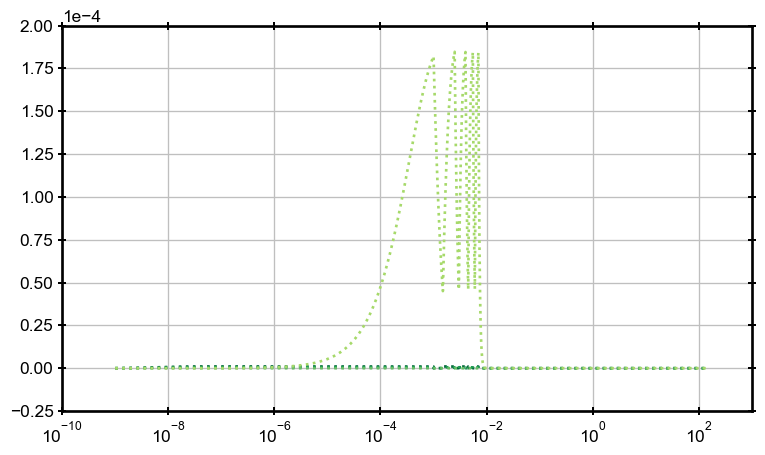

In [71]:
res = all_res[5e-3]
with fig_man.open(f"Reaction with R_r as product") as (fig, ax):
    df_r = all_res[1.5e-3].reconstruct_reactions()
    for reaction in res.env.reactions_involving_product("R_r"):
        ax.semilogx(df_r.index, df_r[reaction.as_label()], label=f"{reaction}", marker="", linestyle=":")

## Compare Pulses

**Integrate values per pulse**

In [51]:
by_pulse = pd.DataFrame(columns=df.columns)
for pulse in range(int(PULSES_NUMBER)):
    by_pulse.loc[pulse, :] = res.integrate_species(start=pulse*uc.beam.timer.period, stop=(pulse+1)*uc.beam.timer.period)

NameError: name 'PULSES_NUMBER' is not defined

In [33]:
by_pulse

,OH_r,O_r_minus,H2O2,HO2_minus,HO2_r,O2_r_minus,e_aq,H_r,H2,O2,O2_minus_minus,O3_minus,Fe_plus_plus_plus,RH_r,R_r,ROO_r,ROH,RO,ROOH
0,0.0,0.0,0.000038,0.0,0.0,0.000002,0.0,0.0,0.000063,9.999233,0.0,0.0,0.0,0.000285,0.000001,0.000615,0.0,0.0,0.0
1,0.0,0.0,0.000044,0.0,0.0,0.000004,0.0,0.0,0.000127,9.999921,0.0,0.000039,0.0,0.00053,0.0,0.000683,0.0,0.0,0.0
2,0.0,0.0,0.000044,0.0,0.0,0.000006,0.0,0.0,0.00019,9.999363,0.0,0.000137,0.0,0.000775,0.0,0.000747,0.0,0.0,0.0
3,0.0,0.0,0.000045,0.0,0.0,0.000007,0.0,0.0,0.000253,9.999367,0.0,0.000272,0.0,0.001022,0.0,0.000829,0.0,0.0,0.0
4,0.0,0.0,0.000044,0.0,0.0,0.000009,0.0,0.0,0.000315,9.953993,0.0,0.000429,0.0,0.001263,0.0,0.000911,0.0,0.0,0.0


### ON time

NameError: name 'by_pulse' is not defined

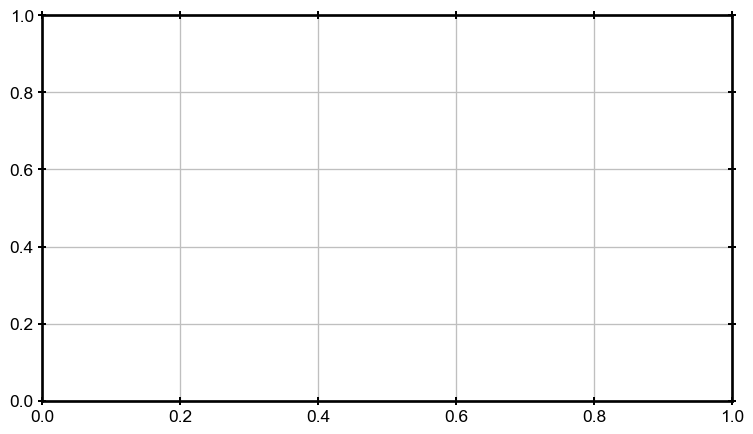

In [50]:
with fig_man.open(f"Pulse Integral") as (fig, ax):
    ax.plot(by_pulse.index+1, by_pulse["ROO_r"], label="ROO_r")
    ax.legend()

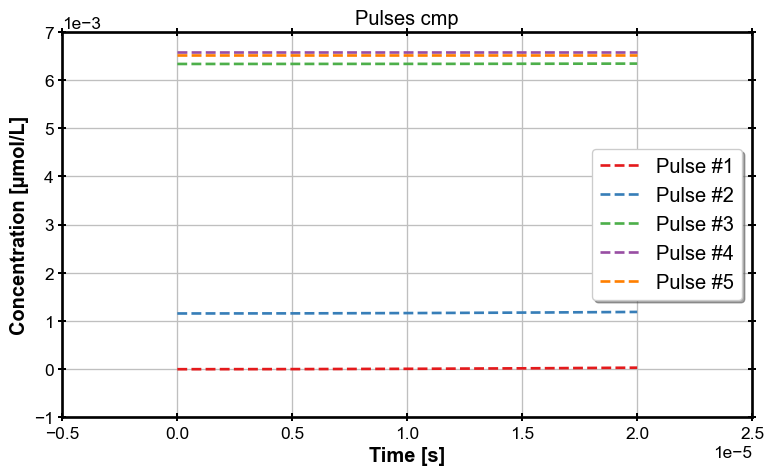

In [27]:
species = "ROO_r"
with fig_man.open(f"Pulses cmp") as (fig, ax):
    for pulse in range(int(PULSES_NUMBER)):
        start_pulse = pulse*uc.beam.timer.period
        mask = (df.index>=start_pulse) & (df.index < start_pulse+uc.beam.timer.on_time)
        ax.plot(df.index[mask]-start_pulse, df.loc[mask, species], label=f"Pulse #{pulse+1}", marker="")

    #ax.set_ylim(bottom=1e-6, top=100)
    #ax.set_xlim([1e-6,1])
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Pulses cmp")

### OFF Time

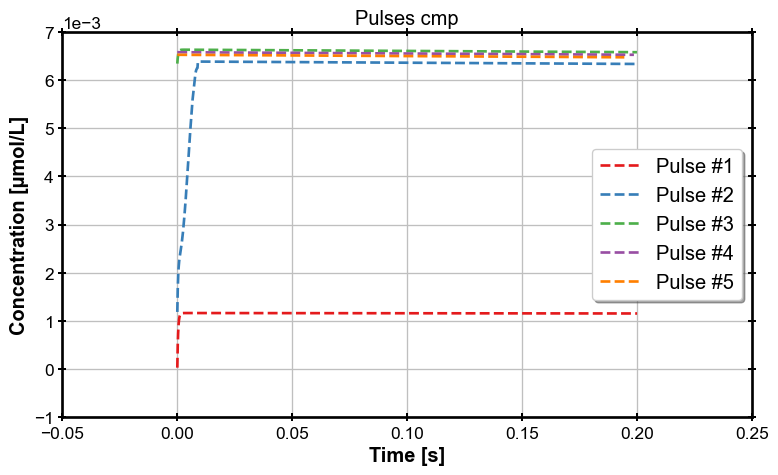

In [28]:
species = "ROO_r"
with fig_man.open(f"Pulses cmp") as (fig, ax):
    for pulse in range(int(PULSES_NUMBER)):
        start_pulse = pulse*uc.beam.timer.period + uc.beam.timer.on_time
        mask = (df.index>=start_pulse) & (df.index < (pulse+1)*uc.beam.timer.period)
        ax.plot(df.index[mask]-start_pulse, df.loc[mask, species], label=f"Pulse #{pulse+1}", marker="")

    #ax.set_ylim(bottom=1e-6, top=100)
    #ax.set_xlim([1e-6,0.12])
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Pulses cmp")